In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from functools import reduce
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import NMF
from sklearn.impute import SimpleImputer

plt.style.use('seaborn-bright')
%matplotlib inline

In [2]:
ratings=pd.read_csv("ml-latest-small/ratings.csv")
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [3]:
movies=pd.read_csv("ml-latest-small/movies.csv")
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [4]:
ratings['rating'].mean()

3.501556983616962

In [5]:
ratings['rating'].mode()

0    4.0
Name: rating, dtype: float64

In [6]:
ftable = pd.crosstab(index=ratings['rating'], columns='rating'.count)
ftable

col_0,<built-in method count of str object at 0x7fad431372f0>
rating,
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


In [7]:
total_rating = ratings['rating'].count()
total_rating

100836

In [8]:
five_star_percent=float(13211 *100//100836)
five_star_percent

13.0

In [9]:
rating_user = ratings.groupby('userId').count()
rating_user

,movieId,rating,timestamp
userId,,,
1,232,232,232
2,29,29,29
3,39,39,39
4,216,216,216
5,44,44,44
...,...,...,...
606,1115,1115,1115
607,187,187,187
608,831,831,831


In [10]:
rating_20 = rating_user.loc[rating_user['rating'] > 20].count()
rating_20

movieId      596
rating       596
timestamp    596
dtype: int64

In [11]:
rating_user['rating'].max()

2698

In [12]:
rating_user['rating'].min()

20

In [13]:
rating_user['rating'].median()

70.5

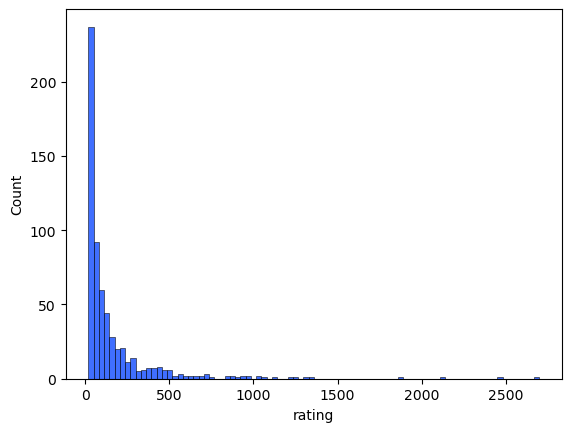

In [14]:
sns.histplot(data=rating_user, x='rating')
sns.set(rc={'figure.figsize':(50,50)})

In [15]:
avg_rating = ratings.groupby('userId').mean()
avg_rating

,movieId,rating,timestamp
userId,,,
1,1854.603448,4.366379,9.649856e+08
2,70350.275862,3.948276,1.445715e+09
3,7058.384615,2.435897,1.306464e+09
4,1982.129630,3.555556,9.658643e+08
5,343.840909,3.636364,8.474351e+08
...,...,...,...
606,9692.197309,3.657399,1.179512e+09
607,1860.636364,3.786096,9.647841e+08
608,4502.605295,3.134176,1.122668e+09


<AxesSubplot:>

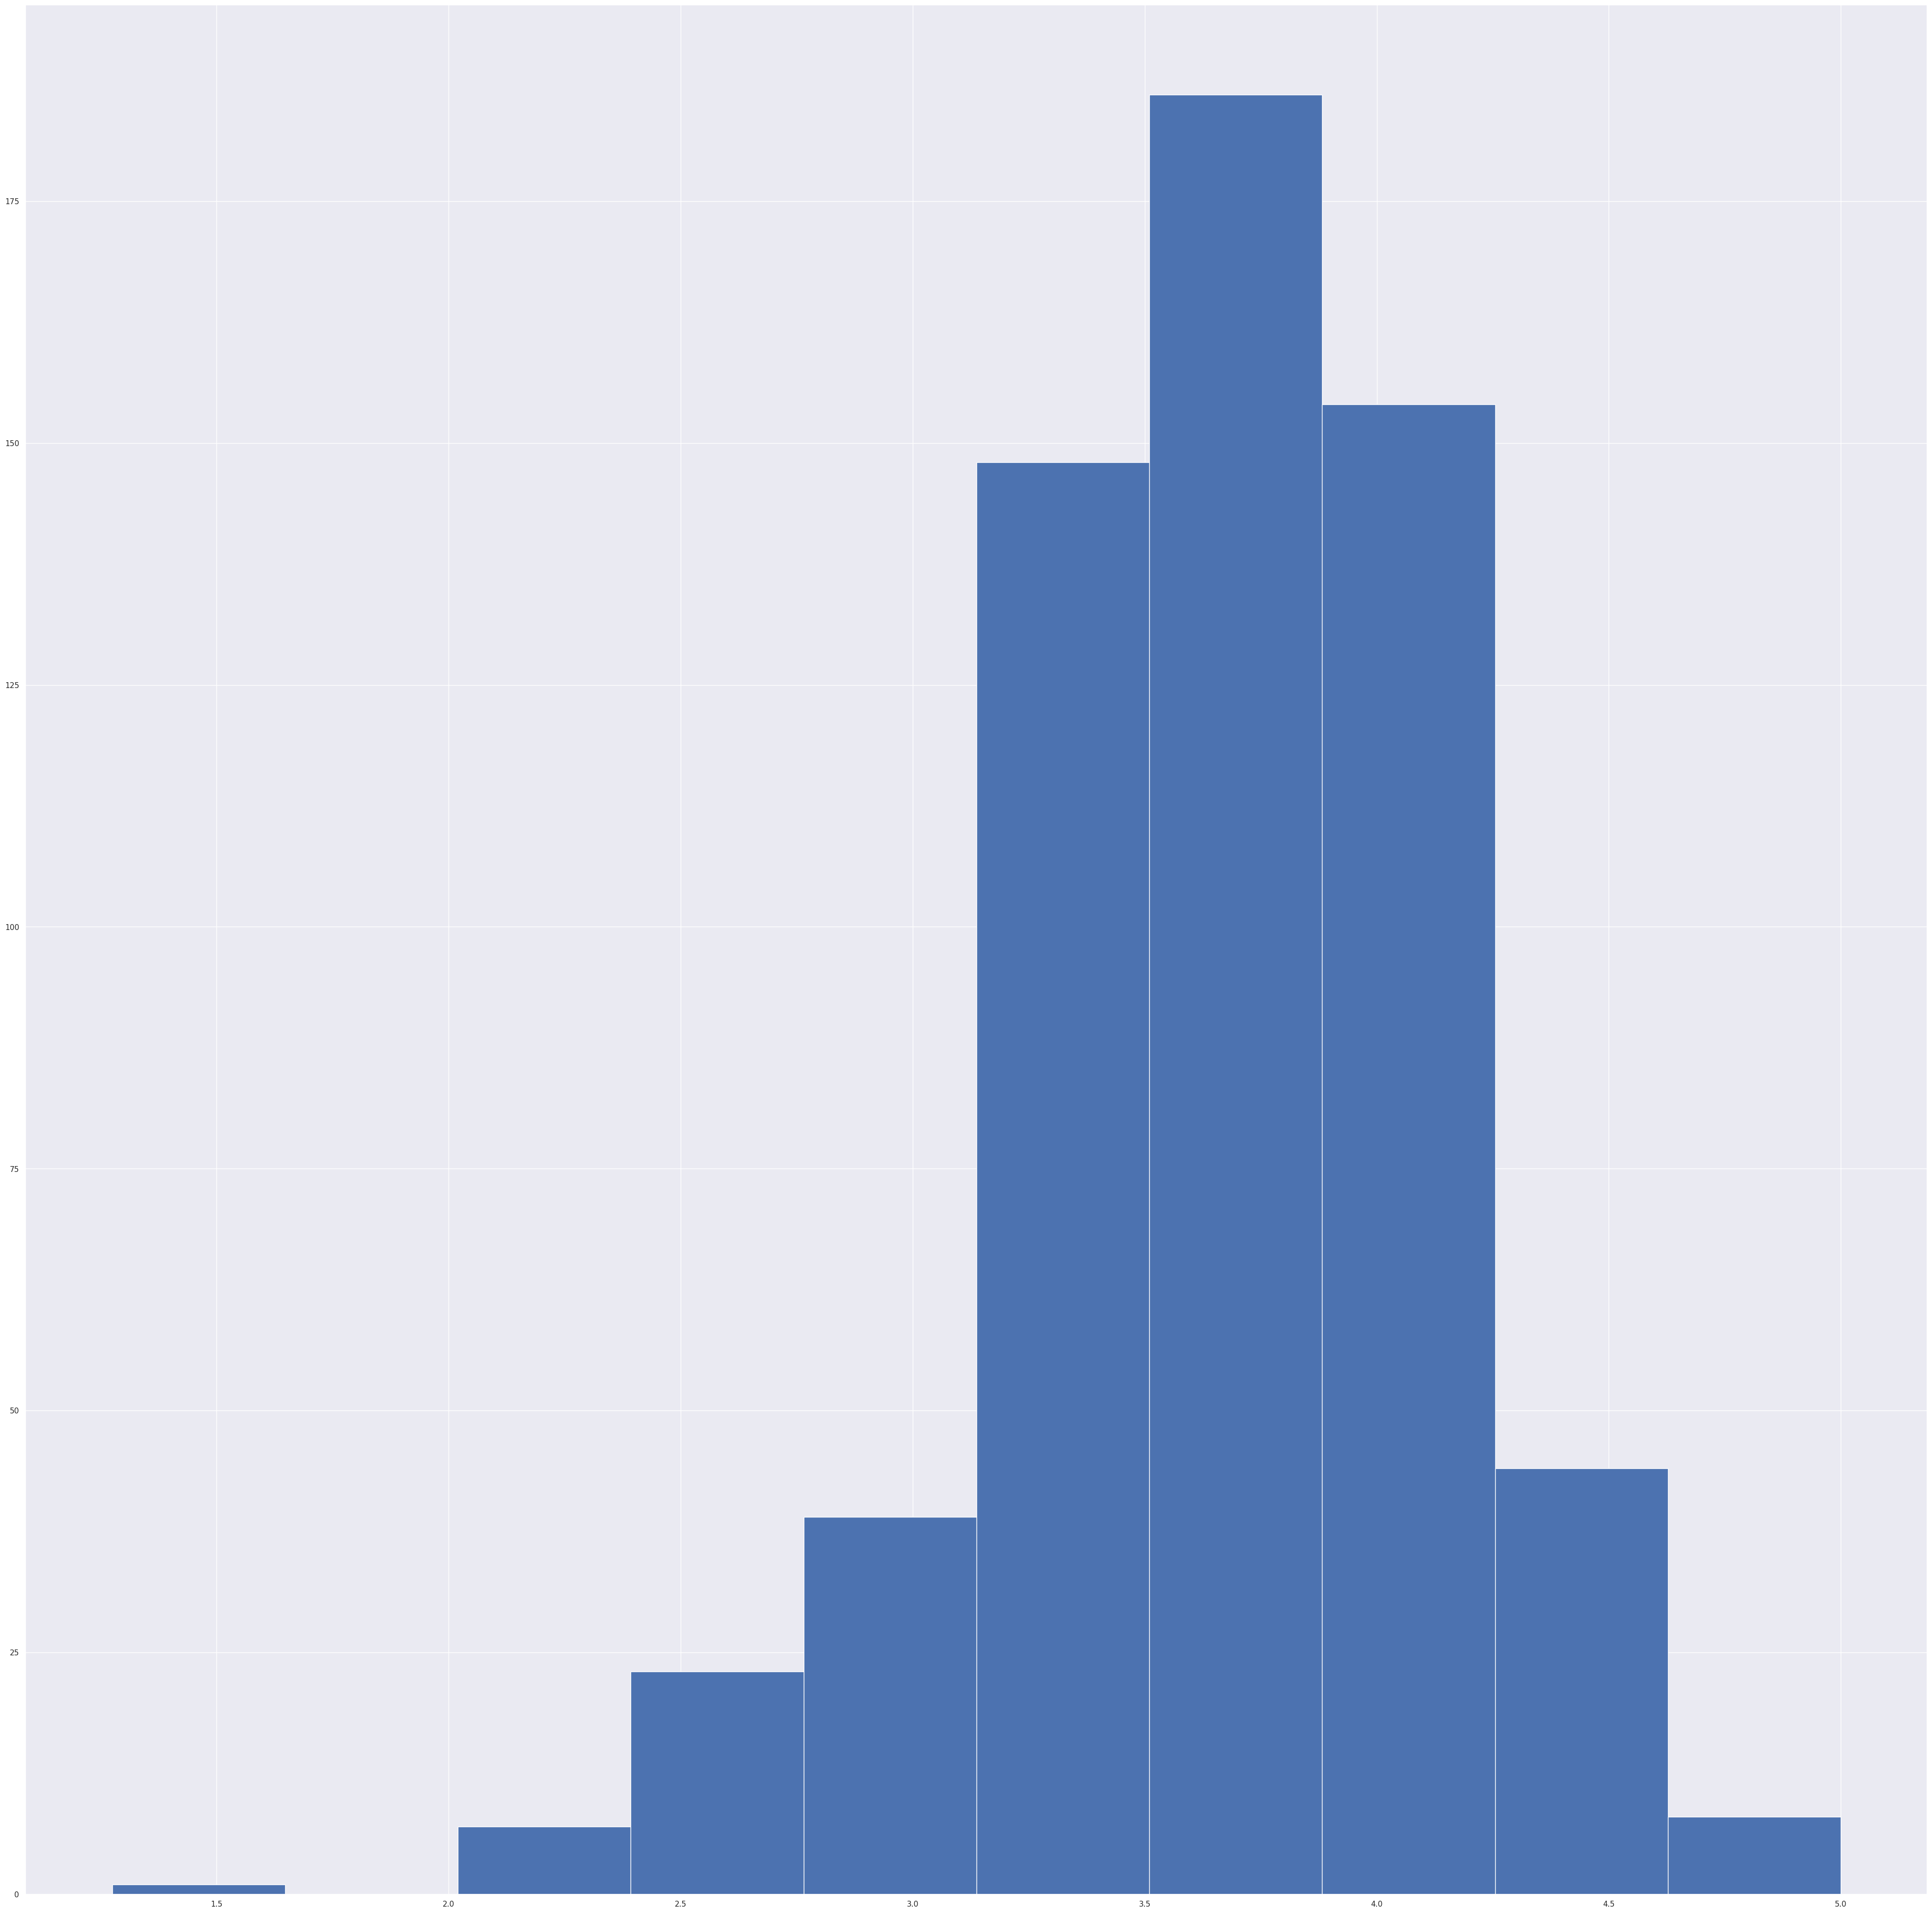

In [16]:
avg_rating['rating'].hist()

In [17]:
movies['title'].duplicated().sum()

5

In [18]:
(~movies['movieId'].isin(ratings['movieId'])).sum()

18

In [19]:
movies.duplicated(subset='title').value_counts()

False    9737
True        5
dtype: int64

In [20]:
movies.drop_duplicates(subset ="title", keep = 'first', inplace = True)

In [21]:
len(movies['movieId'].unique())

9737

In [22]:
len(ratings['movieId'].unique())

9724

In [23]:
df = pd.merge(movies, ratings, on='movieId', how='right')
df

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,3,Grumpier Old Men (1995),Comedy|Romance,1,4.0,964981247
2,6,Heat (1995),Action|Crime|Thriller,1,4.0,964982224
3,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,1,5.0,964983815
4,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,1,5.0,964982931
...,...,...,...,...,...,...
100831,166534,Split (2017),Drama|Horror|Thriller,610,4.0,1493848402
100832,168248,John Wick: Chapter Two (2017),Action|Crime|Thriller,610,5.0,1493850091
100833,168250,Get Out (2017),Horror,610,5.0,1494273047
100834,168252,Logan (2017),Action|Sci-Fi,610,5.0,1493846352


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   movieId    100836 non-null  int64  
 1   title      100830 non-null  object 
 2   genres     100830 non-null  object 
 3   userId     100836 non-null  int64  
 4   rating     100836 non-null  float64
 5   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 5.4+ MB


In [25]:
ratings['average rating'] =pd.DataFrame(df.groupby('movieId')['rating'].mean())
ratings

,userId,movieId,rating,timestamp,average rating
0,1,1,4.0,964982703,NaN
1,1,3,4.0,964981247,3.920930
2,1,6,4.0,964982224,3.431818
3,1,47,5.0,964983815,3.259615
4,1,50,5.0,964982931,2.357143
...,...,...,...,...,...
100831,610,166534,4.0,1493848402,NaN
100832,610,168248,5.0,1493850091,NaN
100833,610,168250,5.0,1494273047,NaN
100834,610,168252,5.0,1493846352,NaN


In [26]:
ratings['num user for each movie'] =pd.DataFrame(ratings.groupby('movieId')['userId'].count())
ratings

,userId,movieId,rating,timestamp,average rating,num user for each movie
0,1,1,4.0,964982703,NaN,NaN
1,1,3,4.0,964981247,3.920930,215.0
2,1,6,4.0,964982224,3.431818,110.0
3,1,47,5.0,964983815,3.259615,52.0
4,1,50,5.0,964982931,2.357143,7.0
...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,NaN,NaN
100832,610,168248,5.0,1493850091,NaN,NaN
100833,610,168250,5.0,1494273047,NaN,NaN
100834,610,168252,5.0,1493846352,NaN,NaN


In [27]:
ratings.sort_values(by=['num user for each movie'],ascending=False)

,userId,movieId,rating,timestamp,average rating,num user for each movie
356,4,919,5.0,945079521,4.164134,329.0
318,4,260,5.0,945079259,4.429022,317.0
296,3,7991,5.0,1306463684,4.197068,307.0
593,6,62,4.0,845553660,4.161290,279.0
2571,19,1625,4.0,965710871,4.192446,278.0
...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,NaN,NaN
100832,610,168248,5.0,1493850091,NaN,NaN
100833,610,168250,5.0,1494273047,NaN,NaN
100834,610,168252,5.0,1493846352,NaN,NaN


In [28]:
ratings[ratings['num user for each movie']<=20]

,userId,movieId,rating,timestamp,average rating,num user for each movie
4,1,50,5.0,964982931,2.357143,7.0
8,1,151,5.0,964984041,2.875000,8.0
9,1,157,5.0,964984100,3.125000,16.0
12,1,223,3.0,964980985,2.421053,19.0
13,1,231,5.0,964981179,3.125000,8.0
...,...,...,...,...,...,...
100579,610,97306,3.5,1493847323,4.000000,1.0
100611,610,101525,4.0,1493847680,4.000000,2.0
100714,610,114707,3.0,1493848404,3.500000,3.0
100737,610,122882,5.0,1493845444,3.500000,1.0


In [29]:
df['title'].isnull().values.any()

True

In [30]:
df.drop(columns=['timestamp', 'genres', 'movieId'], inplace=True)
df

,title,userId,rating
0,Toy Story (1995),1,4.0
1,Grumpier Old Men (1995),1,4.0
2,Heat (1995),1,4.0
3,Seven (a.k.a. Se7en) (1995),1,5.0
4,"Usual Suspects, The (1995)",1,5.0
...,...,...,...
100831,Split (2017),610,4.0
100832,John Wick: Chapter Two (2017),610,5.0
100833,Get Out (2017),610,5.0
100834,Logan (2017),610,5.0


In [31]:
r = df.pivot_table(values='rating', columns='userId', index='title')
r

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
'Hellboy': The Seeds of Creation (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Round Midnight (1986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Salem's Lot (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Til There Was You (1997),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eXistenZ (1999),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,NaN,NaN,4.5,NaN,NaN
xXx (2002),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,NaN,2.0
xXx: State of the Union (2005),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5


# fill the NaNs

In [50]:
r1 = r.fillna(value = 0)
r1.T

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.5,3.5,0.0,0.0,0.0


# Cosine-similarities (Neighborhood-based Collaborative Filtering)

In [33]:
def cos_sim(vec_one, vec_two):
    num = np.dot(vec_one, vec_two)
    denom = np.sqrt(np.dot(vec_one, vec_one)) * np.sqrt(np.dot(vec_two, vec_two))
    return round(num/denom, 2)

In [34]:
vec_one, vec_two = [r1[111], r1[200]]

In [35]:
users = cos_sim(vec_one=vec_one, vec_two=vec_two)
users 

0.28

In [36]:
def user_user_matrix(df):
    total_fillable = list()
    for user in df.columns:

        fillable = list()
        for other_user in df.columns:
            cos_angle = cos_sim(df[user], df[other_user])
            fillable.append(cos_angle)
        
        total_fillable.append(fillable)

    return pd.DataFrame(total_fillable, columns = df.columns, index = df.columns)

In [37]:
user_user = user_user_matrix(r1)
user_user

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.00,0.03,0.06,0.19,0.13,0.13,0.16,0.14,0.06,0.02,...,0.08,0.16,0.22,0.07,0.15,0.16,0.27,0.29,0.09,0.15
2,0.03,1.00,0.00,0.00,0.02,0.03,0.03,0.03,0.00,0.07,...,0.20,0.02,0.01,0.00,0.00,0.03,0.01,0.05,0.03,0.10
3,0.06,0.00,1.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,...,0.01,0.00,0.02,0.00,0.01,0.01,0.02,0.02,0.00,0.03
4,0.19,0.00,0.00,1.00,0.13,0.09,0.12,0.06,0.01,0.03,...,0.09,0.13,0.31,0.05,0.08,0.20,0.13,0.15,0.03,0.11
5,0.13,0.02,0.01,0.13,1.00,0.30,0.11,0.43,0.00,0.03,...,0.07,0.42,0.11,0.26,0.15,0.11,0.15,0.14,0.26,0.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.16,0.03,0.01,0.20,0.11,0.10,0.20,0.10,0.08,0.09,...,0.18,0.12,0.30,0.07,0.15,1.00,0.15,0.26,0.07,0.20
607,0.27,0.01,0.02,0.13,0.15,0.16,0.19,0.19,0.01,0.01,...,0.09,0.20,0.20,0.14,0.12,0.15,1.00,0.28,0.15,0.14
608,0.29,0.05,0.02,0.15,0.14,0.18,0.32,0.19,0.10,0.08,...,0.16,0.20,0.23,0.16,0.18,0.26,0.28,1.00,0.12,0.32


In [38]:
user_user_sklearn = cosine_similarity(r1.T)
user_user_sklearn = pd.DataFrame(user_user_sklearn, columns = r1.columns, index = r1.columns).round(2)
user_user_sklearn

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.00,0.03,0.06,0.19,0.13,0.13,0.16,0.14,0.06,0.02,...,0.08,0.16,0.22,0.07,0.15,0.16,0.27,0.29,0.09,0.15
2,0.03,1.00,0.00,0.00,0.02,0.03,0.03,0.03,0.00,0.07,...,0.20,0.02,0.01,0.00,0.00,0.03,0.01,0.05,0.03,0.10
3,0.06,0.00,1.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,...,0.01,0.00,0.02,0.00,0.01,0.01,0.02,0.02,0.00,0.03
4,0.19,0.00,0.00,1.00,0.13,0.09,0.12,0.06,0.01,0.03,...,0.09,0.13,0.31,0.05,0.08,0.20,0.13,0.15,0.03,0.11
5,0.13,0.02,0.01,0.13,1.00,0.30,0.11,0.43,0.00,0.03,...,0.07,0.42,0.11,0.26,0.15,0.11,0.15,0.14,0.26,0.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.16,0.03,0.01,0.20,0.11,0.10,0.20,0.10,0.08,0.09,...,0.18,0.12,0.30,0.07,0.15,1.00,0.15,0.26,0.07,0.20
607,0.27,0.01,0.02,0.13,0.15,0.16,0.19,0.19,0.01,0.01,...,0.09,0.20,0.20,0.14,0.12,0.15,1.00,0.28,0.15,0.14
608,0.29,0.05,0.02,0.15,0.14,0.18,0.32,0.19,0.10,0.08,...,0.16,0.20,0.23,0.16,0.18,0.26,0.28,1.00,0.12,0.32


In [39]:
#assert user_user.iloc[2,3] == user_user_sklearn.iloc[2,3]

In [40]:
# Step 1: Choose an active user
active_user = 42
df_user = pd.DataFrame(r[active_user])
# Step 2: Create a list of unseen movies for this user
df_user = df_user.loc[df_user[42].isnull()]
df_user

,42
title,
'71 (2014),NaN
'Hellboy': The Seeds of Creation (2004),NaN
'Round Midnight (1986),NaN
'Salem's Lot (2004),NaN
'Til There Was You (1997),NaN
...,...
anohana: The Flower We Saw That Day - The Movie (2013),NaN
eXistenZ (1999),NaN
xXx (2002),NaN


In [41]:
r1.index

Index([''71 (2014)', ''Hellboy': The Seeds of Creation (2004)',
       ''Round Midnight (1986)', ''Salem's Lot (2004)',
       ''Til There Was You (1997)', ''Tis the Season for Love (2015)',
       ''burbs, The (1989)', ''night Mother (1986)',
       '(500) Days of Summer (2009)', '*batteries not included (1987)',
       ...
       'Zulu (2013)', '[REC] (2007)', '[REC]² (2009)',
       '[REC]³ 3 Génesis (2012)',
       'anohana: The Flower We Saw That Day - The Movie (2013)',
       'eXistenZ (1999)', 'xXx (2002)', 'xXx: State of the Union (2005)',
       '¡Three Amigos! (1986)', 'À nous la liberté (Freedom for Us) (1931)'],
      dtype='object', name='title', length=9719)

In [42]:
unseen = r[r[active_user].isna()].index
unseen

Index([''71 (2014)', ''Hellboy': The Seeds of Creation (2004)',
       ''Round Midnight (1986)', ''Salem's Lot (2004)',
       ''Til There Was You (1997)', ''Tis the Season for Love (2015)',
       ''burbs, The (1989)', ''night Mother (1986)',
       '(500) Days of Summer (2009)', '*batteries not included (1987)',
       ...
       'Zulu (1964)', 'Zulu (2013)', '[REC] (2007)', '[REC]² (2009)',
       '[REC]³ 3 Génesis (2012)',
       'anohana: The Flower We Saw That Day - The Movie (2013)',
       'eXistenZ (1999)', 'xXx (2002)', 'xXx: State of the Union (2005)',
       'À nous la liberté (Freedom for Us) (1931)'],
      dtype='object', name='title', length=9279)

In [43]:
# Step 3: Create a list of top 5 similar user
top_five_similar = r[active_user].sort_values(ascending= False).index[1:6]
type(top_five_similar)

pandas.core.indexes.base.Index

In [44]:
# Step 4: For each unseen movies check who has
# rated among the top five similar user
for movie in unseen:
    other_users = r.columns[~r.loc[movie].isna()] #extract users who have rated unseen movies
    other_users = set(other_users) # we want to create an intersection, so we save the users as a set-object
    print(other_users)

{610}
{332}
{377, 332}
{345}
{345, 113}
{21}
{288, 294, 520, 377, 555, 172, 12, 561, 19, 307, 599, 217, 474, 91, 477, 414, 95}
{474}
{509, 141, 525, 15, 143, 18, 148, 22, 280, 153, 538, 414, 159, 41, 298, 177, 564, 317, 62, 318, 448, 68, 70, 73, 331, 462, 213, 599, 89, 92, 477, 610, 483, 357, 358, 232, 105, 489, 490, 491, 249, 125}
{448, 482, 600, 307, 599, 568, 477}
{377}
{368, 474, 332}
{18}
{44}
{448, 345, 156, 271}
{448, 21}
{352, 448, 98, 610, 567, 15, 560, 306, 212, 279, 408, 249, 122, 125}
{232, 545, 608}
{132, 260, 12, 525, 274, 19, 275, 280, 153, 538, 158, 286, 414, 542, 298, 555, 432, 177, 307, 563, 564, 182, 316, 575, 68, 325, 198, 453, 200, 457, 583, 597, 599, 600, 474, 219, 92, 603, 605, 480, 354, 483, 356, 484, 358, 104, 489, 236, 365, 111, 370, 500, 249, 509}
{448}
{256, 318, 545, 387, 68, 292, 414, 200, 232, 398, 432, 560, 86, 249, 28, 509, 158}
{200, 68, 158, 223}
{448}
{517, 269, 146, 19, 20, 274, 276, 151, 32, 288, 545, 294, 169, 171, 45, 432, 177, 50, 563, 314, 318,

{50}
{483, 414}
{599}
{474}
{610, 307}
{160, 603}
{414}
{318}
{385, 387, 517, 527, 27, 288, 290, 421, 39, 295, 555, 51, 182, 183, 438, 313, 57, 186, 572, 64, 577, 68, 199, 462, 590, 469, 217, 603, 221, 483, 357, 362, 238, 367}
{137}
{567}
{480, 484, 232, 298, 111, 274, 307, 406, 599, 408, 414}
{129, 382, 132, 390, 263, 140, 525, 144, 275, 280, 156, 286, 414, 169, 298, 560, 307, 438, 318, 64, 448, 68, 199, 200, 593, 466, 341, 89, 474, 91, 606, 95, 226, 354, 487, 104, 489, 380, 381, 254}
{160, 288, 448, 387, 217, 546, 603, 313, 359, 555, 590, 368, 182, 599, 600, 57, 186, 27}
{288, 234, 555, 527, 414}
{555, 527}
{132, 140, 19, 414, 294, 426, 555, 562, 307, 53, 57, 580, 199, 460, 599, 474, 480, 100, 356}
{59, 85}
{249}
{318}
{448, 610, 232, 298, 274, 249, 381, 414}
{318, 119}
{489, 503}
{448, 610}
{603, 268}
{606}
{448, 10, 483, 517}
{307}
{342}
{606}
{1}
{448, 483, 424, 105, 222}
{113}
{477}
{577, 290, 368, 177, 57, 474, 156, 29}
{514, 387, 4, 260, 135, 263, 522, 525, 398, 274, 275, 22, 2

{448, 21}
{318, 610, 387, 298, 560, 606}
{387}
{125, 62}
{448}
{385, 262, 314, 474, 276, 469, 599, 57, 90, 603}
{578}
{603}
{610, 213}
{64, 288, 480, 68, 517, 298, 139, 140, 432, 474, 221, 414}
{448}
{2, 7, 393, 140, 18, 274, 21, 22, 405, 408, 28, 414, 166, 551, 425, 177, 561, 438, 317, 573, 64, 65, 66, 448, 68, 580, 199, 462, 80, 599, 474, 219, 91, 348, 480, 608, 610, 483, 232, 239, 376, 249, 378, 380}
{610, 36, 140, 82, 438, 249, 380, 573, 414}
{594}
{610}
{318}
{474}
{89}
{599}
{448, 68, 599, 298, 119, 351}
{410, 467}
{448}
{288, 290, 514, 357, 359, 489, 330, 332, 245, 250, 603, 60}
{448, 577, 608, 610, 265, 606, 555, 597, 182, 599, 217, 603, 414}
{603, 414, 479}
{371}
{288, 325, 606}
{420}
{474}
{245}
{305, 567}
{298, 219}
{474, 199}
{89}
{365}
{89}
{414, 599}
{599}
{599}
{202, 368, 465, 599, 474}
{599, 305, 274, 561, 279, 380}
{483}
{96, 288, 132, 4, 356, 104, 265, 202, 266, 552, 500, 597, 603, 156, 414}
{606}
{368, 555}
{448}
{599}
{514}
{414}
{140, 527}
{288, 448, 104, 19, 597, 

{390, 489, 606, 525, 182, 599, 474, 187, 414}
{64, 160, 288, 290, 387, 421, 606, 74, 600, 204, 172, 469, 597, 568, 474, 414, 607}
{346}
{525, 274, 282, 414, 287, 288, 420, 169, 177, 307, 308, 564, 438, 190, 64, 448, 66, 68, 328, 73, 331, 590, 599, 89, 474, 95, 480, 608, 226, 483, 484, 610, 103, 232, 111, 495, 122, 380, 381}
{610, 227, 326, 105, 528, 305, 274, 339, 28, 318}
{227, 326, 528, 305, 339, 318, 351}
{4, 391, 288, 33, 161, 290, 182, 57, 572, 195, 199, 201, 587, 462, 593, 595, 599, 474, 346, 603, 221, 489, 246}
{28, 414}
{232, 480, 414, 606}
{288, 605, 104, 177, 563, 438, 509}
{125}
{9, 74}
{474, 422}
{89}
{448}
{256, 352, 448, 610, 292, 305, 18, 339, 212, 21, 534, 249, 122, 475, 380, 511}
{606}
{89}
{318}
{342}
{210}
{132, 6, 12, 156, 414, 288, 33, 57, 572, 579, 68, 587, 206, 84, 469, 599, 345, 474, 603, 479, 100, 104, 488, 489, 108, 113, 372, 500, 246, 509}
{517, 509}
{318}
{603, 325, 182}
{414}
{89}
{509, 387, 132, 525, 527, 401, 275, 20, 414, 288, 167, 45, 177, 305, 182, 185

{448, 232, 361, 249, 282, 28, 414}
{599}
{140}
{599}
{358, 414, 62}
{256, 387, 132, 18, 414, 416, 298, 560, 305, 182, 318, 190, 578, 199, 74, 83, 600, 474, 346, 606, 227, 356, 249}
{385, 387, 391, 140, 268, 524, 16, 17, 18, 274, 282, 27, 28, 29, 414, 415, 288, 164, 421, 295, 168, 296, 298, 171, 552, 560, 305, 50, 51, 307, 309, 183, 57, 187, 315, 61, 63, 448, 66, 68, 197, 580, 328, 329, 202, 76, 590, 82, 469, 597, 599, 217, 474, 91, 603, 221, 222, 606, 354, 483, 610, 103, 105, 362, 489, 494, 368, 499, 372, 249, 380, 382}
{448, 610, 483, 534, 599}
{89}
{288, 514, 387, 100, 587, 140, 113, 469, 409, 474, 603, 479}
{603, 599}
{474, 221, 590}
{610}
{232, 448, 222, 111}
{160, 129, 288, 6, 294, 136, 583, 240, 177, 274, 401, 20, 436, 600, 476, 380, 477}
{249, 298, 365, 111}
{111}
{1, 514, 387, 525, 17, 274, 19, 20, 406, 534, 280, 153, 414, 160, 288, 418, 292, 294, 552, 298, 172, 45, 177, 561, 307, 562, 55, 57, 313, 573, 64, 448, 195, 68, 328, 590, 212, 215, 599, 217, 474, 600, 477, 605, 606, 48

{298, 111}
{288, 66, 140, 572}
{387, 4, 268, 16, 278, 409, 412, 156, 158, 414, 288, 294, 298, 561, 307, 313, 57, 448, 68, 465, 597, 216, 217, 600, 477, 488, 367}
{66, 226, 294, 136, 559, 240, 284}
{483}
{480, 232, 177, 274, 438, 599, 474, 414}
{68, 357, 166, 232, 525, 462, 318}
{169, 474, 606}
{599}
{318}
{414, 182}
{480, 68, 232, 332, 305, 599, 219, 380}
{599}
{599, 567}
{263, 520, 24, 414, 160, 288, 294, 552, 555, 57, 448, 68, 597, 600, 217, 474, 603, 606, 489, 239, 368}
{177, 474, 357}
{111}
{561}
{111}
{111}
{111}
{111}
{111}
{318}
{339}
{89}
{599}
{610, 232, 20, 380, 414}
{50, 599, 91, 477, 318}
{477, 482, 249, 599, 104, 234, 555, 78, 590, 240, 274, 19, 277, 151, 217, 380, 93, 287}
{68, 298, 525, 52, 318}
{184, 483, 222}
{274, 414, 424, 298, 307, 182, 438, 453, 326, 590, 599, 219, 480, 608, 226, 610, 232, 111, 367, 371, 249}
{298}
{603}
{111}
{111}
{232, 594, 140}
{416, 448, 108, 599, 474, 414, 479}
{608, 226, 135, 492, 51, 19, 307, 217, 414}
{177, 414}
{352, 448, 610, 292, 298, 5

{307, 275, 599, 600, 156, 606}
{606}
{567}
{18}
{168, 18, 204}
{599}
{608, 1, 195, 390, 422, 607, 182, 599, 568, 414, 95}
{274, 387}
{573, 414}
{474, 91, 414}
{288, 469, 175}
{599}
{448, 608, 599, 268, 182, 151, 249}
{603}
{599}
{387, 260, 520, 414, 294, 428, 177, 305, 182, 325, 74, 202, 590, 469, 600, 474, 477, 606, 95, 484, 380}
{608, 387, 260, 325, 390, 606, 560, 177, 599, 380, 477, 414, 95}
{4, 268, 275, 595, 216, 603, 156, 414}
{387, 390, 140, 274, 20, 414, 552, 182, 448, 68, 453, 198, 200, 599, 606, 608, 97, 226, 100, 369, 500, 119, 382}
{599}
{414}
{603, 294}
{448, 480, 226, 610, 140, 438, 249, 219, 380, 414}
{19, 151, 540, 414, 158, 32, 288, 307, 182, 448, 68, 214, 599, 600, 217, 603, 606, 480, 608, 226, 483, 234, 508}
{387, 292, 414, 326, 232, 74, 111, 177, 18, 305, 52, 339, 219, 28, 317, 318, 127}
{160, 288, 480, 6, 313, 391, 606, 599, 57, 474, 414}
{380}
{438}
{89}
{599}
{483, 318}
{560, 105, 318, 263}
{514}
{448, 89}
{599}
{289, 28}
{387, 391, 140, 275, 22, 23, 409, 414, 28

{387}
{19, 380, 387}
{599}
{260}
{482, 68, 517, 7, 232, 489, 177, 148, 21, 438, 596, 509}
{232, 329, 603}
{529, 19, 151, 414, 32, 171, 57, 314, 448, 470, 599, 217, 602, 93, 232, 492, 240, 374, 380}
{226}
{606}
{389, 6, 263, 521, 268, 151, 414, 32, 288, 162, 171, 428, 431, 304, 437, 438, 572, 448, 321, 451, 68, 71, 456, 330, 335, 337, 84, 596, 214, 599, 474, 91, 477, 350, 480, 608, 226, 483, 356, 102, 489, 492, 109, 239, 117, 120}
{222}
{259, 517, 6, 268, 524, 14, 142, 18, 404, 411, 28, 541, 286, 159, 414, 33, 162, 38, 552, 174, 47, 559, 177, 305, 562, 308, 436, 437, 438, 58, 570, 446, 447, 323, 68, 580, 70, 200, 584, 202, 589, 462, 590, 84, 596, 599, 600, 474, 602, 603, 222, 606, 480, 608, 226, 100, 229, 357, 235, 108, 365, 112, 372, 117, 373, 121}
{474}
{128, 4, 517, 138, 268, 156, 28, 412, 290, 177, 309, 186, 188, 587, 590, 84, 469, 599, 216, 345, 89, 474, 603, 221, 606, 357, 488, 367, 508}
{448, 517}
{483}
{89}
{387, 393, 140, 525, 274, 28, 414, 298, 560, 182, 317, 573, 64, 448, 68,

{387, 390, 16, 275, 160, 288, 290, 555, 51, 182, 440, 442, 66, 595, 84, 597, 599, 600, 345, 603, 221, 606, 489}
{610, 68, 599, 199, 28, 275, 20, 182, 343, 474, 603, 156, 414, 95}
{389, 6, 136, 520, 521, 270, 529, 19, 276, 277, 284, 543, 294, 169, 428, 179, 437, 438, 448, 66, 68, 207, 337, 84, 599, 604, 477, 350, 483, 362, 492, 240, 501}
{372, 199}
{448}
{318}
{4, 19, 469, 312, 474, 603, 606}
{474}
{288, 312, 387, 298, 139, 22, 599, 216, 474, 380, 414}
{160, 385, 448, 387, 608, 486, 559, 240, 592, 596, 181, 599, 217, 602, 91, 605, 414, 479}
{288, 385, 162, 603, 5, 199, 392, 265, 587, 474, 84, 117, 346, 411}
{448, 600, 387}
{1, 414, 182}
{1, 139, 274, 19, 20, 155, 292, 293, 428, 182, 438, 448, 453, 82, 600, 603, 352, 610, 249}
{288, 474, 414}
{288, 19, 217, 474, 414}
{232, 140}
{233}
{325, 294, 479}
{599}
{514, 517, 525, 19, 33, 554, 555, 45, 562, 57, 572, 64, 579, 68, 587, 590, 591, 593, 594, 595, 597, 599, 91, 603, 93, 606, 95, 96, 100, 101, 103, 104, 129, 132, 144, 153, 156, 160, 166,

{474}
{514, 212, 567, 184, 414}
{610}
{233}
{526}
{305, 125, 599}
{318, 352, 514, 414, 610, 599, 328, 41, 560, 305, 50, 339, 212, 413, 249, 122, 125, 62}
{18}
{50, 414, 62}
{256, 318, 352, 291, 68, 249, 382, 551, 105, 298, 586, 462, 305, 534, 153, 475, 380, 62}
{599}
{111}
{10}
{325, 555, 19, 313, 91, 571}
{256, 509, 139, 141, 525, 15, 18, 21, 534, 280, 414, 418, 292, 551, 560, 177, 305, 561, 308, 563, 567, 443, 62, 63, 318, 68, 582, 73, 586, 332, 461, 80, 466, 211, 212, 475, 222, 606, 352, 610, 503, 357, 103, 104, 105, 495, 247, 248, 249, 378, 123, 380, 125, 511}
{256, 525, 18, 21, 418, 292, 551, 177, 563, 567, 443, 318, 62, 63, 68, 328, 586, 339, 475, 222, 610, 105, 248, 249, 380, 509}
{525, 18, 21, 30, 292, 177, 561, 443, 318, 190, 62, 68, 73, 586, 596, 475, 352, 610, 495, 119, 248, 249, 509}
{352, 610, 292, 586, 21, 567, 248, 249, 475, 62}
{537}
{448, 50, 567}
{603}
{256, 515, 517, 523, 525, 18, 148, 21, 408, 25, 414, 418, 550, 551, 560, 177, 50, 305, 567, 184, 317, 62, 318, 65, 32

{434, 298}
{448, 610, 292, 599, 551, 298, 523, 365, 18, 596, 534, 567, 249, 122, 380, 62}
{398}
{606}
{318}
{318, 351}
{305}
{50}
{448, 474, 414, 599}
{410, 603, 156, 318}
{474, 606}
{474, 606}
{177, 606, 414, 391}
{610, 351}
{448}
{509}
{160, 132, 391, 359, 489, 597, 216, 410, 603, 606}
{216, 474, 606}
{462}
{25, 18, 153}
{132, 4, 260, 140, 410, 156, 28, 414, 288, 552, 298, 561, 182, 438, 448, 599, 474, 603, 606, 480, 483, 508}
{153}
{380}
{318, 414, 567, 599, 462, 212, 596, 380, 184, 249, 252, 125, 62}
{603, 387}
{410, 414}
{608, 387, 484, 274, 307, 562, 414}
{610}
{474, 477, 414}
{474, 219, 414}
{47}
{384, 387, 268, 19, 275, 410, 414, 288, 552, 572, 577, 200, 201, 202, 597, 599, 217, 474, 603, 606, 100, 489}
{448, 177, 274, 249, 474, 414}
{414}
{15, 534, 292, 298, 305, 567, 443, 318, 448, 68, 73, 80, 339, 352, 610, 483, 365, 249, 380}
{474, 410}
{89}
{474}
{560, 567}
{318, 599}
{318, 352, 448, 414, 292, 483, 610, 298, 537, 212, 534, 279, 408, 249, 122, 380, 125, 62}
{480, 414, 326, 

In [49]:
# Step 5: Create ratings for the active user
# predict the rating based on the (weighted) average ratings of the other user: 
# sum(ratings*similarity)/sum(similarities)
for movie in unseen:
    other_users = r.columns[~r.loc[movie].isna()] 
    other_users = set(other_users)

    num = 0
    den = 0
    for user in set(top_five_similar).intersection(other_users): 
        ratings = user_item[user][movie]     # extract relevant ratings from user_item
        sim = user_user[active_user][user]   # extract relevant cosine sim values 
        num = num + (ratings*sim)            # account for "level of similarity"
        den = den + sim 
    
    pred_ratings = num/(den+ 0.000001)
    print(movie, pred_ratings)

'71 (2014) 0.0
'Hellboy': The Seeds of Creation (2004) 0.0
'Round Midnight (1986) 0.0
'Salem's Lot (2004) 0.0
'Til There Was You (1997) 0.0
'Tis the Season for Love (2015) 0.0
'burbs, The (1989) 0.0
'night Mother (1986) 0.0
(500) Days of Summer (2009) 0.0
*batteries not included (1987) 0.0
...All the Marbles (1981) 0.0
...And Justice for All (1979) 0.0
00 Schneider - Jagd auf Nihil Baxter (1994) 0.0
1-900 (06) (1994) 0.0
10 (1979) 0.0
10 Cent Pistol (2015) 0.0
10 Cloverfield Lane (2016) 0.0
10 Items or Less (2006) 0.0
10 Things I Hate About You (1999) 0.0
10 Years (2011) 0.0
10,000 BC (2008) 0.0
100 Girls (2000) 0.0
100 Streets (2016) 0.0
101 Dalmatians (1996) 0.0
101 Dalmatians (One Hundred and One Dalmatians) (1961) 0.0
101 Dalmatians II: Patch's London Adventure (2003) 0.0
101 Reykjavik (101 Reykjavík) (2000) 0.0
102 Dalmatians (2000) 0.0
10th & Wolf (2006) 0.0
10th Kingdom, The (2000) 0.0
10th Victim, The (La decima vittima) (1965) 0.0
11'09"01 - September 11 (2002) 0.0
11:14 (2003

Andrew Dice Clay: Dice Rules (1991) 0.0
Android (1982) 0.0
Andromeda Strain, The (1971) 0.0
Angel Baby (1995) 0.0
Angel Eyes (2001) 0.0
Angel Heart (1987) 0.0
Angel at My Table, An (1990) 0.0
Angel's Egg (Tenshi no tamago) (1985) 0.0
Angel-A (2005) 0.0
Angela's Ashes (1999) 0.0
Angels & Demons (2009) 0.0
Angels and Insects (1995) 0.0
Angels with Dirty Faces (1938) 0.0
Angels' Share, The (2012) 0.0
Anger Management (2003) 0.0
Angie (1994) 0.0
Angriest Man in Brooklyn, The (2014) 0.0
Angry Red Planet, The (1959) 0.0
Angst  (1983) 0.0
Angus (1995) 0.0
Angus, Thongs and Perfect Snogging (2008) 0.0
Animal Crackers (1930) 0.0
Animal Factory (2000) 0.0
Animal Farm (1954) 0.0
Animal House (1978) 0.0
Animal, The (2001) 0.0
Animals are Beautiful People (1974) 0.0
Animatrix, The (2003) 0.0
Anna Christie (1930) 0.0
Anna Karenina (1935) 0.0
Anna Karenina (1997) 0.0
Anna Karenina (2012) 0.0
Anna and the King (1999) 0.0
Annabelle (2014) 0.0
Annabelle: Creation (2017) 0.0
Annapolis (2006) 0.0
Anne Fra

Best in Show (2000) 0.0
Best of Youth, The (La meglio gioventù) (2003) 0.0
Best of the Best (1989) 0.0
Best of the Best 3: No Turning Back (1995) 0.0
Betrayed (1988) 0.0
Betsy's Wedding (1990) 0.0
Better Living Through Chemistry (2014) 0.0
Better Living Through Circuitry (1999) 0.0
Better Luck Tomorrow (2002) 0.0
Better Off Dead... (1985) 0.0
Better Than Chocolate (1999) 0.0
Better Than Sex (2000) 0.0
Better Tomorrow II, A (Ying hung boon sik II) (1987) 0.0
Better Tomorrow, A (Ying hung boon sik) (1986) 0.0
Betting on Zero (2016) 0.0
Between Your Legs (Entre las piernas) (1999) 0.0
Between the Folds (2008) 0.0
Beverly Hillbillies, The (1993) 0.0
Beverly Hills Chihuahua (2008) 0.0
Bewitched (2005) 0.0
Beyond Bedlam (1993) 0.0
Beyond Borders (2003) 0.0
Beyond Rangoon (1995) 0.0
Beyond Re-Animator (2003) 0.0
Beyond Silence (Jenseits der Stille) (1996) 0.0
Beyond the Clouds (Al di là delle nuvole) (1996) 0.0
Beyond the Mat (1999) 0.0
Beyond the Poseidon Adventure (1979) 0.0
Beyond the Sea 

Cimarron (1931) 0.0
Cincinnati Kid, The (1965) 0.0
Cinderella (1950) 0.0
Cinderella (1997) 0.0
Cinderella (2015) 0.0
Cinderella Man (2005) 0.0
Cinderella Story, A (2004) 0.0
Cinema Paradiso (Nuovo cinema Paradiso) (1989) 0.0
Cinemania (2002) 0.0
Circle of Friends (1995) 0.0
Circle, The (Dayereh) (2000) 0.0
Circus (2000) 0.0
Circus, The (1928) 0.0
Cirque du Freak: The Vampire's Assistant (2009) 0.0
Citizen Kane (1941) 0.0
Citizen Ruth (1996) 0.0
Citizen X (1995) 0.0
Citizenfour (2014) 0.0
City Hall (1996) 0.0
City Heat (1984) 0.0
City Hunter (Sing si lip yan) (1993) 0.0
City Island (2009) 0.0
City Lights (1931) 0.0
City by the Sea (2002) 0.0
City of Ember (2008) 0.0
City of God (Cidade de Deus) (2002) 0.0
City of Lost Children, The (Cité des enfants perdus, La) (1995) 0.0
City of Lost Souls, The (Hyôryuu-gai) (2000) 0.0
City of Men (Cidade dos Homens) (2007) 0.0
City of Women, The (Città delle donne, La) (1980) 0.0
City of the Living Dead (a.k.a. Gates of Hell, The) (Paura nella città d

Duets (2000) 0.0
Dukes of Hazzard, The (2005) 0.0
Duma (2005) 0.0
Dumb and Dumber To (2014) 0.0
Dumb and Dumberer: When Harry Met Lloyd (2003) 0.0
Dumbo (1941) 0.0
Dummy (2002) 0.0
Dune (1984) 0.0
Dune (2000) 0.0
Dungeons & Dragons (2000) 0.0
Dunkirk (2017) 0.0
Dunston Checks In (1996) 0.0
Duplex (2003) 0.0
Duplicity (2009) 0.0
Dust (2001) 0.0
Dutch (1991) 0.0
Dying Young (1991) 0.0
Dying of the Light (2014) 0.0
Dylan Moran: Monster (2004) 0.0
Déjà Vu (1997) 0.0
Déjà Vu (Deja Vu) (2006) 0.0
EDtv (1999) 0.0
Eagle Eye (2008) 0.0
Eagle Has Landed, The (1976) 0.0
Eagle, The (2011) 0.0
Ear, The (Ucho) (1970) 0.0
Earth (2007) 0.0
Earth Girls Are Easy (1988) 0.0
Earth vs. the Flying Saucers (1956) 0.0
Earthlings (2006) 0.0
Earthquake (1974) 0.0
Earthsea (Legend of Earthsea) (2004) 0.0
East is East (1999) 0.0
East of Eden (1955) 0.0
East-West (Est-ouest) (1999) 0.0
Easter Parade (1948) 0.0
Eastern Promises (2007) 0.0
Easy A (2010) 0.0
Easy Money (1983) 0.0
Easy Rider (1969) 0.0
Eat Drink Man W

Ginger Snaps: Unleashed (2004) 0.0
Gingerbread Man, The (1998) 0.0
Gintama (2017) 0.0
Gintama: The Final Chapter - Be Forever Yorozuya (2013) 0.0
Gintama: The Movie (2010) 0.0
Girl Next Door, The (2004) 0.0
Girl Next Door, The (2007) 0.0
Girl Walks Home Alone at Night, A (2014) 0.0
Girl Walks Into a Bar (2011) 0.0
Girl Who Kicked the Hornet's Nest, The (Luftslottet som sprängdes) (2009) 0.0
Girl Who Leapt Through Time, The (Toki o kakeru shôjo) (2006) 0.0
Girl Who Played with Fire, The (Flickan som lekte med elden) (2009) 0.0
Girl on the Bridge, The (Fille sur le pont, La) (1999) 0.0
Girl with a Pearl Earring (2003) 0.0
Girl with the Dragon Tattoo, The (2011) 0.0
Girl with the Dragon Tattoo, The (Män som hatar kvinnor) (2009) 0.0
Girlfight (2000) 0.0
Girls About Town (1931) 0.0
Girls Just Want to Have Fun (1985) 0.0
Girls! Girls! Girls! (1962) 0.0
Girltrash: All Night Long (2014) 0.0
Giver, The (2014) 0.0
Gladiator (1992) 0.0
Glass House, The (2001) 0.0
Glass Menagerie, The (1987) 0.0


Hurricane, The (1999) 0.0
Hurt Locker, The (2008) 0.0
Husbands and Wives (1992) 0.0
Hush (1998) 0.0
Hush (2016) 0.0
Hush... Hush, Sweet Charlotte (1964) 0.0
Hustle & Flow (2005) 0.0
Hustler White (1996) 0.0
Hustler, The (1961) 0.0
Hyde Park on Hudson (2012) 0.0
Hyena Road 0.0
Hype! (1996) 0.0
HyperNormalisation (2016) 0.0
Hysteria (2011) 0.0
I Am David (2003) 0.0
I Am Legend (2007) 0.0
I Am Not Your Negro (2017) 0.0
I Am Number Four (2011) 0.0
I Am Sam (2001) 0.0
I Am Trying to Break Your Heart (2002) 0.0
I Am Wrath (2016) 0.0
I Am a Fugitive from a Chain Gang (1932) 0.0
I Am a Sex Addict (2005) 0.0
I Bought a Vampire Motorcycle (1990) 0.0
I Can't Think Straight (2007) 0.0
I Capture the Castle (2003) 0.0
I Confess (1953) 0.0
I Do: How to Get Married and Stay Single (Prête-moi ta main) (2006) 0.0
I Don't Know How She Does It (2011) 0.0
I Heart Huckabees (2004) 0.0
I Kill Giants (2018) 0.0
I Killed My Mother (J'ai tué ma mère) (2009) 0.0
I Know Who Killed Me (2007) 0.0
I Like It Like Tha

Late Marriage (Hatuna Meuheret) (2001) 0.0
Late Night Shopping (2001) 0.0
Late Night with Conan O'Brien: The Best of Triumph the Insult Comic Dog (2004) 0.0
Late Shift, The (1996) 0.0
Latter Days (2003) 0.0
Laura (1944) 0.0
Laurel Canyon (2002) 0.0
Lavender Hill Mob, The (1951) 0.0
Law Abiding Citizen (2009) 0.0
Law of Desire (Ley del deseo, La) (1987) 0.0
Lawless (2012) 0.0
Lawnmower Man 2: Beyond Cyberspace (1996) 0.0
Lawnmower Man, The (1992) 0.0
Lawrence of Arabia (1962) 0.0
Laws of Attraction (2004) 0.0
Layer Cake (2004) 0.0
Le Maître d'école (1981) 0.0
League of Extraordinary Gentlemen, The (a.k.a. LXG) (2003) 0.0
League of Ordinary Gentlemen, A (2004) 0.0
Lean on Me (1989) 0.0
Leap Year (2010) 0.0
Leap of Faith (1992) 0.0
Leatherheads (2008) 0.0
Leave It to Beaver (1997) 0.0
Leaves of Grass (2009) 0.0
Leaving Las Vegas (1995) 0.0
Ledge, The (2011) 0.0
Lee Daniels' The Butler (2013) 0.0
Left Behind: The Movie (2000) 0.0
Legal Eagles (1986) 0.0
Legally Blonde (2001) 0.0
Legally Bl

Moustache, La (2005) 0.0
Movie 43 (2013) 0.0
Mozart and the Whale (2005) 0.0
Mr Hublot (2013) 0.0
Mr. & Mrs. Smith (1941) 0.0
Mr. & Mrs. Smith (2005) 0.0
Mr. 3000 (2004) 0.0
Mr. Baseball (1992) 0.0
Mr. Bean's Holiday (2007) 0.0
Mr. Blandings Builds His Dream House (1948) 0.0
Mr. Brooks (2007) 0.0
Mr. Death: The Rise and Fall of Fred A. Leuchter, Jr. (1999) 0.0
Mr. Deeds (2002) 0.0
Mr. Deeds Goes to Town (1936) 0.0
Mr. Destiny (1990) 0.0
Mr. Holland's Opus (1995) 0.0
Mr. Holmes (2015) 0.0
Mr. Jealousy (1997) 0.0
Mr. Magoo (1997) 0.0
Mr. Mom (1983) 0.0
Mr. Nanny (1993) 0.0
Mr. Nice Guy (Yat goh ho yan) (1997) 0.0
Mr. Nobody (2009) 0.0
Mr. Peabody & Sherman (2014) 0.0
Mr. Popper's Penguins (2011) 0.0
Mr. Right (2016) 0.0
Mr. Saturday Night (1992) 0.0
Mr. Skeffington (1944) 0.0
Mr. Smith Goes to Washington (1939) 0.0
Mr. Wonderful (1993) 0.0
Mr. Woodcock (2007) 0.0
Mr. Wrong (1996) 0.0
Mrs. Brown (a.k.a. Her Majesty, Mrs. Brown) (1997) 0.0
Mrs. Dalloway (1997) 0.0
Mrs. Doubtfire (1993) 0.0

Performance (1970) 0.0
Perfume: The Story of a Murderer (2006) 0.0
Perks of Being a Wallflower, The (2012) 0.0
Permanent Midnight (1998) 0.0
Persepolis (2007) 0.0
Persona (1966) 0.0
Personal Velocity (2002) 0.0
Persuasion (1995) 0.0
Persuasion (2007) 0.0
Pervert's Guide to Cinema, The (2006) 0.0
Pervert's Guide to Ideology, The (2012) 0.0
Pest, The (1997) 0.0
Pet Sematary (1989) 0.0
Pet Sematary II (1992) 0.0
Pete's Dragon (1977) 0.0
Pete's Dragon (2016) 0.0
Peter Pan (1953) 0.0
Peter Pan (1960) 0.0
Peter Pan (2003) 0.0
Peter's Friends (1992) 0.0
Peyton Place (1957) 0.0
Phantasm (1979) 0.0
Phantasm II (1988) 0.0
Phantasm III: Lord of the Dead (1994) 0.0
Phantasm IV: Oblivion (1998) 0.0
Phantom Thread (2017) 0.0
Phantom Tollbooth, The (1970) 0.0
Phantom of the Opera, The (2004) 0.0
Phantom of the Paradise (1974) 0.0
Phantom, The (1996) 0.0
Phantoms (1998) 0.0
Phenomena (a.k.a. Creepers) (1985) 0.0
Phenomenon (1996) 0.0
Phil Spector (2013) 0.0
Philadelphia (1993) 0.0
Philadelphia Experim

Room with a View, A (1986) 0.0
Room, The (2003) 0.0
Roommate, The (2011) 0.0
Roommates (1995) 0.0
Roots (1977) 0.0
Rope (1948) 0.0
Rory O'Shea Was Here (Inside I'm Dancing) (2004) 0.0
Rory Scovel Tries Stand-Up for the First Time (2017) 0.0
Rose Red (2002) 0.0
Rose Tattoo, The (1955) 0.0
Rosemary's Baby (1968) 0.0
Rosencrantz and Guildenstern Are Dead (1990) 0.0
Rosetta (1999) 0.0
Rosewood (1997) 0.0
Rough Magic (1995) 0.0
Rough Night (2017) 0.0
Rounders (1998) 0.0
Roxanne (1987) 0.0
Royal Flash (1975) 0.0
Royal Tenenbaums, The (2001) 0.0
Royal Wedding (1951) 0.0
Rubber (2010) 0.0
Ruby & Quentin (Tais-toi!) (2003) 0.0
Ruby Red (2013) 0.0
Ruby Sparks (2012) 0.0
Ruby in Paradise (1993) 0.0
Rudderless (2014) 0.0
Rude Boy (1980) 0.0
Rudolph, the Red-Nosed Reindeer (1964) 0.0
Rugrats Movie, The (1998) 0.0
Rugrats in Paris: The Movie (2000) 0.0
Ruins, The (2008) 0.0
Rules of Attraction, The (2002) 0.0
Rules of Engagement (2000) 0.0
Rules of the Game, The (La règle du jeu) (1939) 0.0
Ruling C

Steve Jobs: The Man in the Machine (2015) 0.0
Stevie (2002) 0.0
Stick It (2006) 0.0
Stigmata (1999) 0.0
Still Alice (2014) 0.0
Still Crazy (1998) 0.0
Still Walking (Aruitemo aruitemo) (2008) 0.0
Sting, The (1973) 0.0
Stingray Sam (2009) 0.0
Stir Crazy (1980) 0.0
Stir of Echoes (1999) 0.0
Stitch! The Movie (2003) 0.0
Stoked: The Rise and Fall of Gator (2002) 0.0
Stoker (2013) 0.0
Stolen Children (Ladro di bambini, Il) (1992) 0.0
Stolen Summer (2002) 0.0
Stomp the Yard (2007) 0.0
Stone (2010) 0.0
Stone Reader (2002) 0.0
Stoned (2005) 0.0
Stonewall (2015) 0.0
Stoning of Soraya M., The (2008) 0.0
Stop Making Sense (1984) 0.0
Stop! Or My Mom Will Shoot (1992) 0.0
Stop-Loss (2008) 0.0
Storks (2016) 0.0
Story of Film: An Odyssey, The (2011) 0.0
Story of O, The (Histoire d'O) (1975) 0.0
Story of Us, The (1999) 0.0
Story of Women (Affaire de femmes, Une) (1988) 0.0
Story of the Weeping Camel, The (Geschichte vom weinenden Kamel, Die) (2003) 0.0
Storytelling (2001) 0.0
Strada, La (1954) 0.0
Stra

The Jane Austen Book Club (2007) 0.0
The Jinx: The Life and Deaths of Robert Durst (2015) 0.0
The Jungle Book (2016) 0.0
The Lair of the White Worm (1988) 0.0
The Last Five Years (2014) 0.0
The Last Witch Hunter (2015) 0.0
The Legend of Tarzan (2016) 0.0
The Lego Batman Movie (2017) 0.0
The Lego Movie (2014) 0.0
The Little Prince (2015) 0.0
The Little World of Don Camillo (1952) 0.0
The Lobster (2015) 0.0
The Loft (2014) 0.0
The Longest Ride (2015) 0.0
The Longest Week (2014) 0.0
The Lord's Lantern in Budapest (1999) 0.0
The Lost Room (2006) 0.0
The Love Bug (1997) 0.0
The Lovers (2015) 0.0
The Machinist (2004) 0.0
The Madagascar Penguins in a Christmas Caper (2005) 0.0
The Magic Ring (1982) 0.0
The Magician (1958) 0.0
The Magnificent Ruffians (1979) 0.0
The Magnificent Seven (2016) 0.0
The Maid's Room (2014) 0.0
The Malibu Bikini Shop (1986) 0.0
The Man Who Killed Don Quixote (2018) 0.0
The Man Who Knew Infinity (2016) 0.0
The Man from Nowhere (2010) 0.0
The Man from U.N.C.L.E. (2015)

Undisputed (2002) 0.0
Undisputed II: Last Man Standing (2006) 0.0
Undisputed III: Redemption (2010) 0.0
Unedited Footage of a Bear (2014) 0.0
Unfaithful (2002) 0.0
Unfaithfully Yours (1948) 0.0
Unfinished Business (2015) 0.0
Unfinished Life, An (2005) 0.0
Unforgettable (1996) 0.0
Unforgettable Summer, An (Un été inoubliable) (1994) 0.0
Unforgiven (2013) 0.0
Unforgiven, The (1960) 0.0
Unicorn City (2012) 0.0
Unintentional Kidnapping of Mrs. Elfriede Ott, The (Die Unabsichtliche Entführung der Frau Elfriede Ott) (2010) 0.0
Uninvited, The (2009) 0.0
Union: The Business Behind Getting High, The (2007) 0.0
United 93 (2006) 0.0
United States of Leland, The (2003) 0.0
Universal Soldier (1992) 0.0
Universal Soldier: Day of Reckoning (2012) 0.0
Universal Soldier: The Return (1999) 0.0
Unknown (2006) 0.0
Unknown (2011) 0.0
Unknown Known, The (2013) 0.0
Unknown White Male (2005) 0.0
Unlawful Entry (1992) 0.0
Unleashed (Danny the Dog) (2005) 0.0
Unprecedented: The 2000 Presidential Election (2002)

# Non-negative Matrix factorization (NMF)

In [51]:
model = NMF(n_components=5, max_iter= 500)  

In [52]:
x = r1.T
x.shape

(610, 9719)

In [53]:
x.to_csv("new_data.csv")

In [54]:
model.fit(x)

/home/henda/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


NMF(max_iter=500, n_components=5)

In [55]:
Q = model.components_
Q

array([[0.        , 0.        , 0.00523132, ..., 0.        , 0.39934308,
        0.00528687],
       [0.06341042, 0.        , 0.        , ..., 0.08144784, 0.06385737,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.02108774, 0.01717104, ..., 0.00253762, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.15829065,
        0.        ]])

In [56]:
x.shape

(610, 9719)

In [57]:
Q_df = pd.DataFrame(model.components_, columns=x.columns)
Q_df

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
0,0.00000,0.000000,0.005231,0.003329,0.000337,0.000000,0.295354,0.000000,0.000000,0.083623,...,0.010086,0.026199,0.00000,0.000000,0.000000,0.244158,0.053433,0.000000,0.399343,0.005287
1,0.06341,0.000000,0.000000,0.000000,0.000000,0.010358,0.022955,0.000000,0.637079,0.064438,...,0.015150,0.208959,0.10279,0.093925,0.005504,0.000000,0.387284,0.081448,0.063857,0.000000
2,0.00000,0.000000,0.000000,0.000000,0.000298,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.020859,0.000000,0.000000,0.000000
3,0.00000,0.021088,0.017171,0.000000,0.000000,0.000000,0.000000,0.000000,0.134895,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.071181,0.000000,0.002538,0.000000,0.000000
4,0.00000,0.000000,0.000000,0.002409,0.013465,0.000000,0.083233,0.117218,0.067133,0.032909,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.371073,0.037100,0.000000,0.158291,0.000000


In [58]:
P = model.transform(x)
P

array([[2.02079447, 0.        , 0.29515588, 0.19940981, 0.        ],
       [0.        , 0.10046629, 0.        , 0.33237013, 0.        ],
       [0.07830777, 0.        , 0.        , 0.        , 0.        ],
       ...,
       [2.0630808 , 1.59131512, 0.79068106, 1.12839616, 0.12136635],
       [0.        , 0.        , 0.80732961, 0.04319524, 0.        ],
       [0.42509756, 5.05639115, 0.        , 1.54672974, 0.20312572]])

In [59]:
P_df = pd.DataFrame(P, columns=['feature1', 'feature2', 'feature3', 'feature4', 'feature5'], index=x.index)
P_df

,feature1,feature2,feature3,feature4,feature5
userId,,,,,
1,2.020794,0.000000,0.295156,0.199410,0.000000
2,0.000000,0.100466,0.000000,0.332370,0.000000
3,0.078308,0.000000,0.000000,0.000000,0.000000
4,0.605335,0.000000,0.061689,0.125545,0.999909
5,0.000000,0.000000,1.117635,0.026863,0.040199
...,...,...,...,...,...
606,0.000000,0.000000,0.029333,2.037946,4.676031
607,1.241716,0.000000,0.715407,0.118293,0.000000
608,2.063081,1.591315,0.790681,1.128396,0.121366


In [60]:
model.reconstruction_err_

965.241460897897

In [61]:
R = pd.DataFrame(np.dot(P, Q).round(), index=x.index, columns=x.columns)
R

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0
607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [62]:
x

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.5,3.5,0.0,0.0,0.0


In [63]:
user = x.loc[x.index == 100,:].values
user.shape

(1, 9719)

In [64]:
user_P = model.transform(user)          # how strongly our user likes the 5 "genres"
user_P

/home/henda/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but NMF was fitted with feature names
  warnings.warn(


array([[0.3616755 , 0.00477749, 0.67712042, 0.01392318, 0.64582355]])

In [65]:
user_R = np.dot(user_P,Q)

In [66]:
user_R[0]

array([0.00030294, 0.00029361, 0.00213112, ..., 0.00042445, 0.24696552,
       0.00191213])

In [67]:
user[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [68]:
recommendation = pd.DataFrame({'user_input':user[0], 'predicted_ratings':user_R[0]}, index = x.columns)
recommendation

,user_input,predicted_ratings
title,,
'71 (2014),0.0,0.000303
'Hellboy': The Seeds of Creation (2004),0.0,0.000294
'Round Midnight (1986),0.0,0.002131
'Salem's Lot (2004),0.0,0.002760
'Til There Was You (1997),0.0,0.009020
...,...,...
eXistenZ (1999),0.0,0.328945
xXx (2002),0.0,0.059260
xXx: State of the Union (2005),0.0,0.000424


In [ ]:
import pickle
with open('./nmf_recommender.pkl', 'wb') as file:
    pickle.dump(model, file)